## ЛАБ 2

## Введение
Целью данной работы является анализ ассоциативных правил для данных о совместных покупках товаров. В работе применяются алгоритмы Apriori и FPGrowth для выявления паттернов покупок, оценивается влияние параметров алгоритмов на получаемые правила, проводится визуализация результатов и предлагается собственный способ представления ассоциативных правил.

Вариант дата сета - 3.

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import networkx as nx

import pandas as pd

all_data = pd.read_csv('ds.csv', on_bad_lines='skip')
print(all_data)

       Lassi  Coffee Powder         Butter        Yougurt    Ghee Cheese  \
0       Ghee  Coffee Powder            NaN            NaN     NaN    NaN   
1      Lassi     Tea Powder         Butter         Cheese     NaN    NaN   
2     Cheese     Tea Powder         Panner  Coffee Powder  Butter  Bread   
3     Cheese        Yougurt  Coffee Powder          Sugar  Butter  Sweet   
4      Sugar     Tea Powder           Ghee          Sweet  Panner   Milk   
...      ...            ...            ...            ...     ...    ...   
8726  Panner          Sugar          Bread           Milk  Cheese    NaN   
8727   Sugar          Bread  Coffee Powder         Cheese     NaN    NaN   
8728   Bread         Cheese        Yougurt           Milk     NaN    NaN   
8729    Ghee          Bread        Yougurt          Sugar  Cheese    NaN   
8730  Panner        Yougurt          Bread            NaN     NaN    NaN   

      Unnamed: 6  
0            NaN  
1            NaN  
2            NaN  
3          

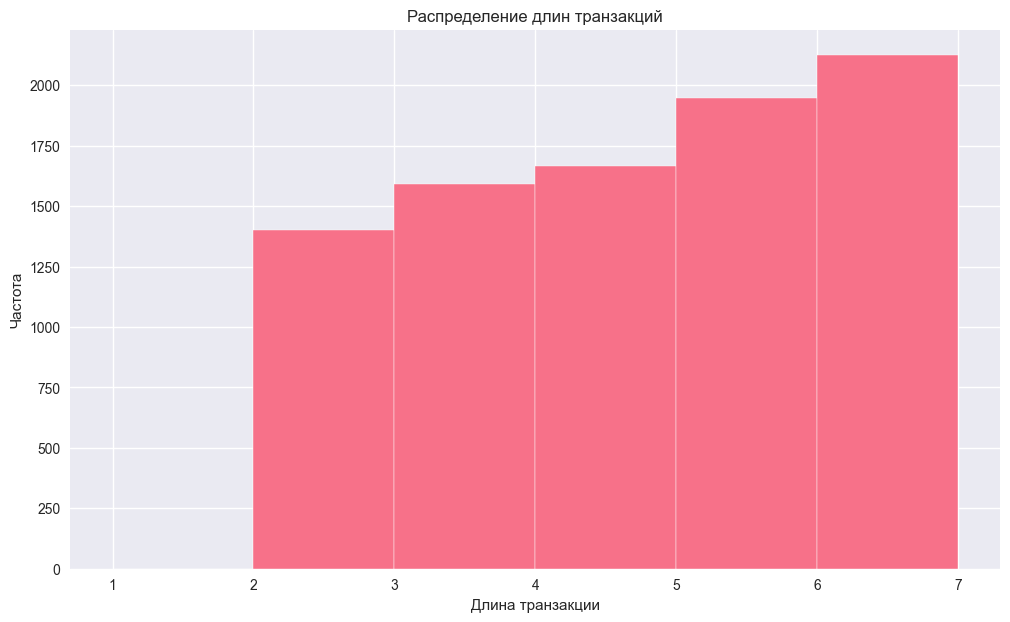

Минимальная длина транзакции: 2
Максимальная длина транзакции: 6
Средняя длина транзакции: 4.21
Медиана длины транзакции: 4.0


In [101]:
transaction_lengths = all_data.notnull().sum(axis=1)
plt.hist(transaction_lengths, bins=range(1, max(transaction_lengths) + 2))
plt.xlabel('Длина транзакции')
plt.ylabel('Частота')
plt.title('Распределение длин транзакций')
plt.show()

print(f"Минимальная длина транзакции: {transaction_lengths.min()}")
print(f"Максимальная длина транзакции: {transaction_lengths.max()}")
print(f"Средняя длина транзакции: {transaction_lengths.mean():.2f}")
print(f"Медиана длины транзакции: {transaction_lengths.median()}")


In [102]:

np_data = all_data.to_numpy()
np_data = [[elem for elem in row[1:] if isinstance(elem,str)] for row in np_data]
unique_items = set()
for row in np_data:
    for elem in row:
        unique_items.add(elem)
print(f"Уникальных товаров: {len(unique_items)}")
print(unique_items)


te = TransactionEncoder()
te_ary = te.fit(np_data).transform(np_data)
data = pd.DataFrame(te_ary, columns=te.columns_)

Уникальных товаров: 12
{'Coffee Powder', 'Butter', 'Milk', 'Tea Powder', 'Bread', 'Sugar', 'Panner', 'Sweet', 'Lassi', 'Yougurt', 'Ghee', 'Cheese'}


     support               itemsets
0   0.268583                (Bread)
1   0.264002               (Butter)
2   0.271561               (Cheese)
3   0.269729        (Coffee Powder)
4   0.274654                 (Ghee)
..       ...                    ...
73  0.066659    (Sugar, Tea Powder)
74  0.068263       (Sugar, Yougurt)
75  0.068263    (Sweet, Tea Powder)
76  0.066774       (Yougurt, Sweet)
77  0.068606  (Yougurt, Tea Powder)

[78 rows x 2 columns]
       antecedents      consequents   support  confidence      lift
0         (Panner)          (Bread)  0.071813    0.272609  1.014988
1         (Butter)           (Ghee)  0.072386    0.274187  0.998300
2  (Coffee Powder)           (Ghee)  0.075707    0.280679  1.021940
3           (Ghee)  (Coffee Powder)  0.075707    0.275646  1.021940
4  (Coffee Powder)        (Yougurt)  0.074218    0.275159  1.015391
5        (Yougurt)  (Coffee Powder)  0.074218    0.273880  1.015391
6          (Sweet)           (Ghee)  0.072958    0.273039  0.994122
7

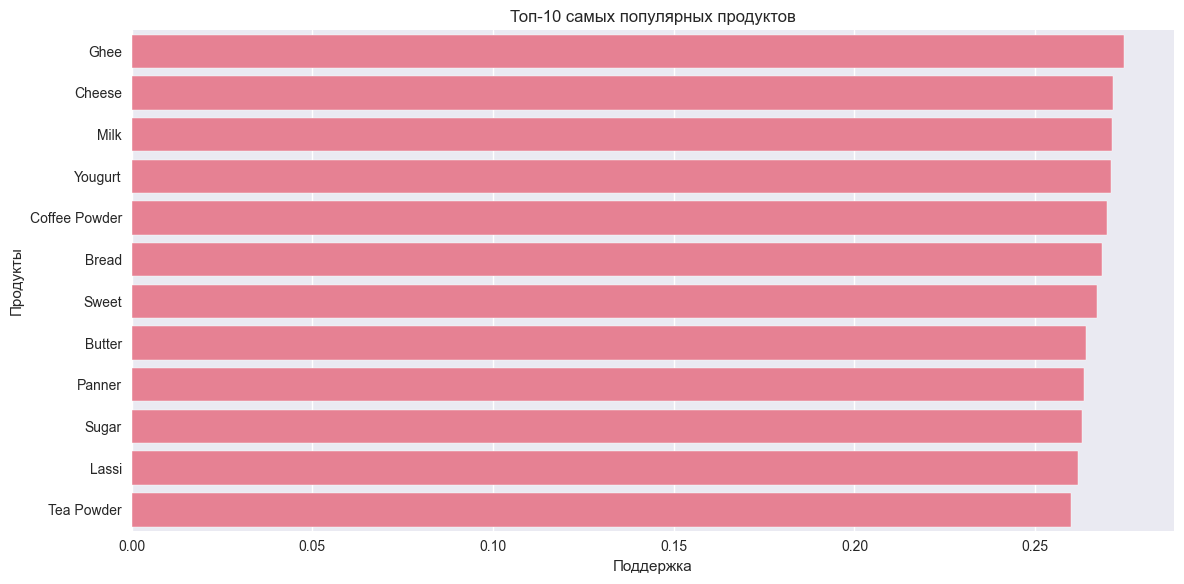

Средняя поддержка для продуктов: 0.267171


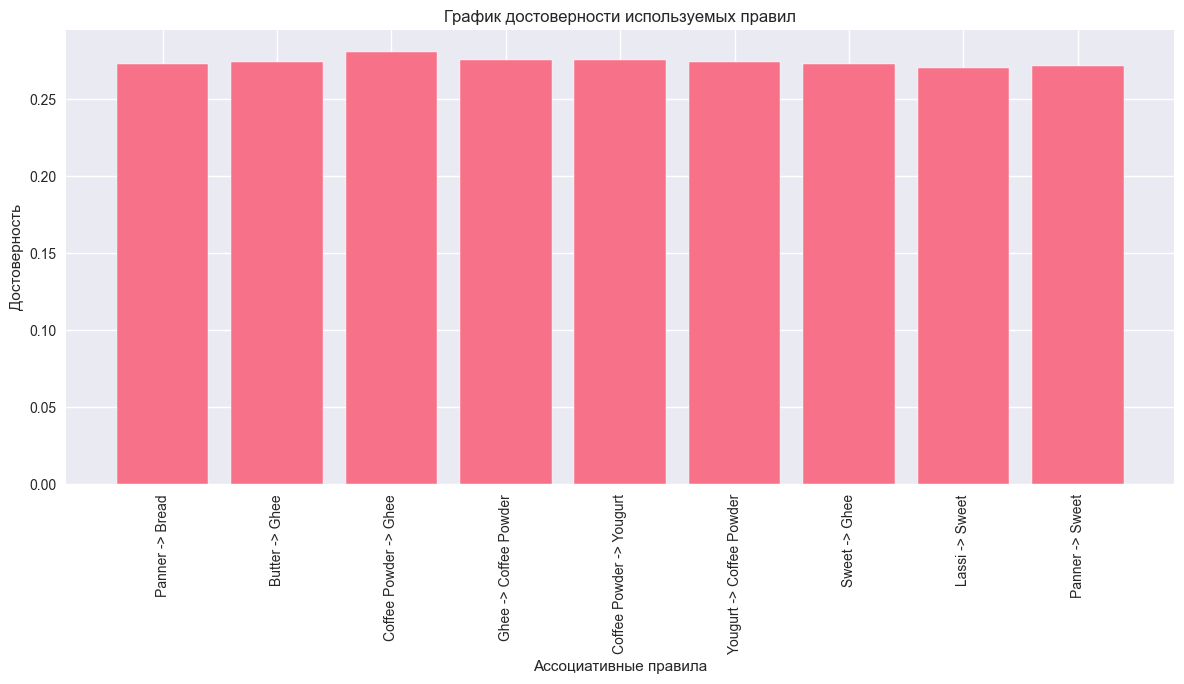

<Figure size 1200x800 with 0 Axes>

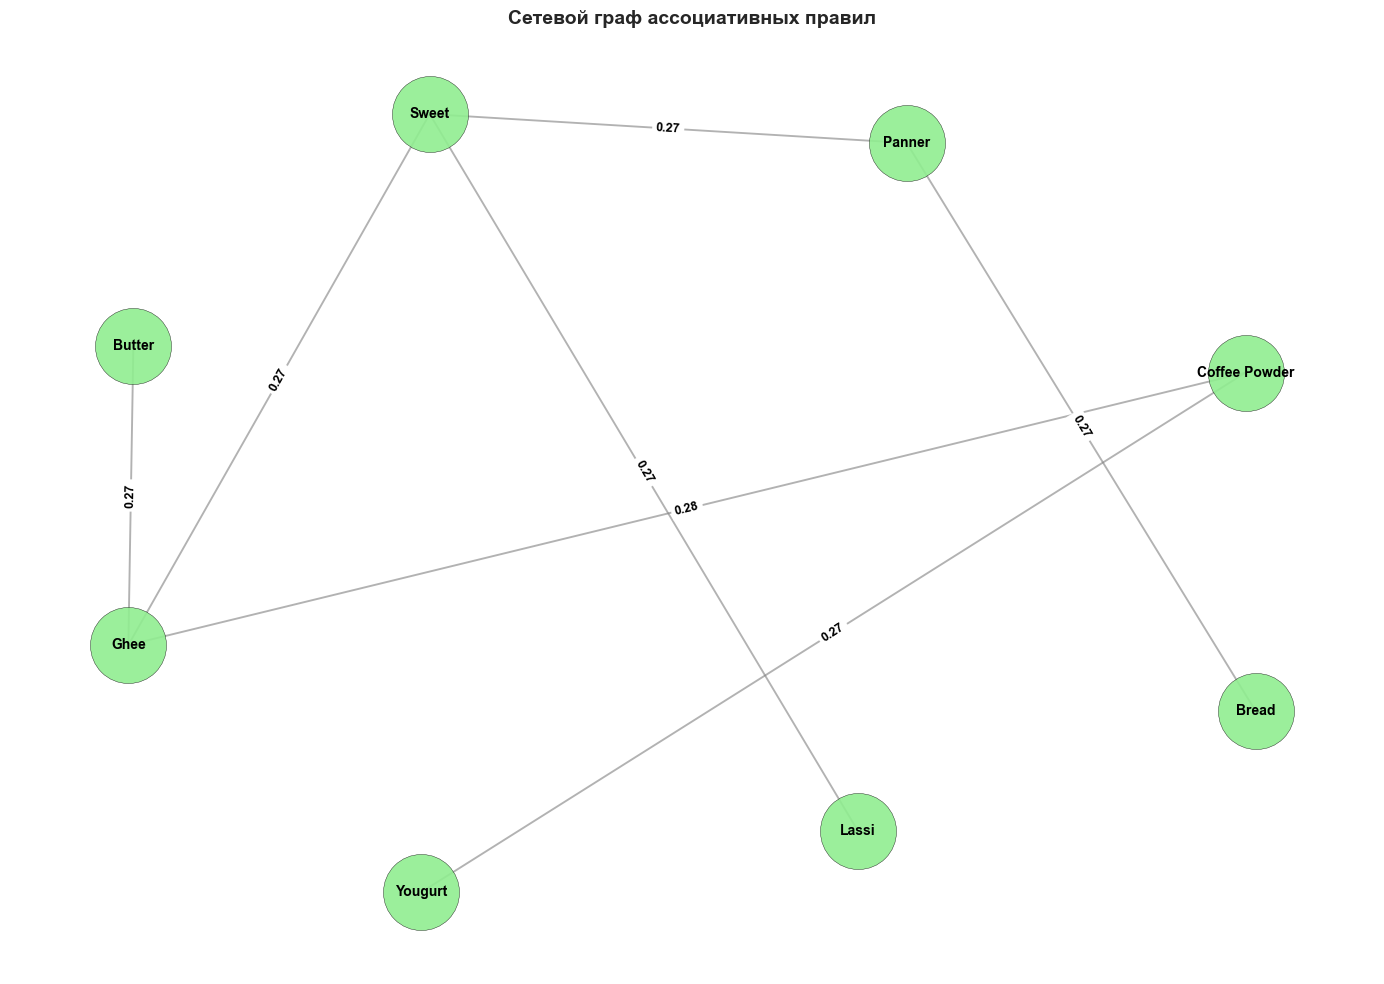

In [103]:

df1 = apriori(data, min_support=0.03, use_colnames = True)
print(df1)
rules = association_rules(df1, metric = "confidence", min_threshold = 0.27)
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

df1['itemsets'] = df1['itemsets'].apply(lambda x: ', '.join(list(x)))
top_products = df1.sort_values(by='support', ascending=False).head(12)
print(top_products)
plt.figure(figsize=(12, 6))
sns.barplot(x='support', y='itemsets', data=top_products)
plt.title('Топ-10 самых популярных продуктов')
plt.xlabel('Поддержка')
plt.ylabel('Продукты')
plt.tight_layout()
plt.show()
rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))

print(f"Средняя поддержка для продуктов: {top_products['support'].mean():.6f}")

products_1 = rules["antecedents"].tolist()
products_2 = rules["consequents"].tolist()
confidence = rules["confidence"].tolist()
rules_labels = [f"{product1} -> {product2}" for product1, product2 in zip(products_1, products_2)]
plt.bar(rules_labels, confidence)
plt.xlabel("Ассоциативные правила")
plt.ylabel("Достоверность")
plt.title("График достоверности используемых правил")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))

G = nx.Graph()

for index, row in rules.iterrows():
    G.add_edge(row['antecedents'], row['consequents'], weight=row['confidence'])


pos = nx.spring_layout(G, k=3, iterations=50)

plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(G, pos,
                      node_size=3000,
                      node_color='lightgreen',
                      alpha=0.9,
                      edgecolors='black')

edge_widths = [d['weight'] * 5 for (u, v, d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos,
                      width=edge_widths,
                      alpha=0.6,
                      edge_color='gray')


nx.draw_networkx_labels(G, pos,
                       font_size=10,
                       font_weight='bold',
                       font_family='sans-serif')


edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos,
                            edge_labels=edge_labels,
                            font_size=9,
                            font_weight='bold')

plt.title('Сетевой граф ассоциативных правил', fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

# Особенности распределения поддержки
Поддержка одиночных товаров варьируется в узком диапазоне: 0.259-0.275, Равномерное распределение популярности - нет явных лидеров.
Средняя поддержка для топ-продуктов: 0.269

Обнаружено 9 ассоциативных правил, все правила имеют структуру "один товар -> один товар".

Отсутствуют правила с множественными антецедентами или консеквентами

Метрики качества правил
* Значения lift: Диапазон: 0.994 - 1.022
* Среднее значение: ≈1.013
* Максимальное значение: 1.022 (Coffee Powder → Ghee)

Значения confidence:

* Диапазон: 0.270 - 0.281
* Среднее значение: 0.274

Наиболее значимые правила:
Coffee Powder → Ghee: Support: 0.076 Confidence: 0.281 Lift: 1.022 (максимальный)

Ghee → Coffee Powder: Support: 0.076 Confidence: 0.276 Lift: 1.022


In [104]:

results = []
supports = [0.01, 0.02, 0.065]
confidences = [0.1, 0.25, 0.3]

for sup in supports:
    for conf in confidences:
        freq_items = apriori(data, min_support=sup, use_colnames=True)
        rule_set = association_rules(freq_items, metric="confidence", min_threshold=conf)

        num_rules = len(rule_set)
        avg_confidence = rule_set['confidence'].mean() if num_rules > 0 else 0
        avg_lift = rule_set['lift'].mean() if num_rules > 0 else 0
        useful_rules = len(rule_set[rule_set['lift'] > 1])

        results.append({
            'support': sup,
            'confidence': conf,
            'num_rules': num_rules,
            'avg_confidence': avg_confidence,
            'avg_lift': avg_lift,
        })

results_df = pd.DataFrame(results)
print(results_df)


   support  confidence  num_rules  avg_confidence  avg_lift
0    0.010        0.10        792        0.236994  0.887077
1    0.010        0.25        209        0.260096  0.969416
2    0.010        0.30          0        0.000000  0.000000
3    0.020        0.10        132        0.256656  0.960664
4    0.020        0.25         99        0.260235  0.971279
5    0.020        0.30          0        0.000000  0.000000
6    0.065        0.10        124        0.257377  0.962355
7    0.065        0.25         99        0.260235  0.971279
8    0.065        0.30          0        0.000000  0.000000


In [105]:
df1 = fpgrowth(data, min_support=0.04, use_colnames = True)
print(df1)
rules = association_rules(df1, metric = "confidence", min_threshold = 0.24)
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

     support          itemsets
0   0.269729   (Coffee Powder)
1   0.271561          (Cheese)
2   0.264002          (Butter)
3   0.259993      (Tea Powder)
4   0.268583           (Bread)
..       ...               ...
73  0.064826    (Lassi, Sugar)
74  0.069981     (Lassi, Milk)
75  0.067690    (Lassi, Bread)
76  0.068835   (Lassi, Cheese)
77  0.068263  (Lassi, Yougurt)

[78 rows x 2 columns]
         antecedents      consequents   support  confidence      lift
0    (Coffee Powder)        (Yougurt)  0.074218    0.275159  1.015391
1          (Yougurt)  (Coffee Powder)  0.074218    0.273880  1.015391
2    (Coffee Powder)           (Ghee)  0.075707    0.280679  1.021940
3             (Ghee)  (Coffee Powder)  0.075707    0.275646  1.021940
4    (Coffee Powder)         (Cheese)  0.070210    0.260297  0.958522
..               ...              ...       ...         ...       ...
124          (Bread)          (Lassi)  0.067690    0.252026  0.962991
125          (Lassi)         (Cheese)  0.0688

Эксперимент демонстрирует высокую чувствительность алгоритма к выбору параметров support и confidence:

Наблюдаемые проблемы:

* При confidence ≥ 0.30 правила вообще не находятся
* Резкое сокращение количества правил при увеличении confidence с 0.10 до 0.27
* Ограниченный диапазон рабочих значений confidence (0.10-0.27)

In [106]:

def find_min_support_for_item_count(data, max_items=5, min_supp_start=0.000001):
    df1 = fpgrowth(data, min_support=min_supp_start, use_colnames=True)
    rules = association_rules(df1, metric="confidence", min_threshold=0.0)

    results = {}

    for item_count in range(1, max_items + 1):
        df1['items_count'] = df1['itemsets'].apply(len)
        itemsets_filtered = df1[df1['items_count'] == item_count]

        print(f"Наборы из {item_count} товара(ов):")

        if len(itemsets_filtered) > 0:
            min_support = itemsets_filtered['support'].min()
            max_support = itemsets_filtered['support'].max()
            print(f"Минимальный support: {min_support:.6f}")
            print(f"Максимальный support: {max_support:.6f}")
            print(f"Количество наборов: {len(itemsets_filtered)}")

            # Выводим несколько примеров
            for idx, row in itemsets_filtered.head(3).iterrows():
                items = list(row['itemsets'])
                print(f"  {items}: support={row['support']:.4f}")

            results[item_count] = min_support
        else:
            print("Нет наборов для такого количества товаров")
            results[item_count] = None

        print("-" * 50)

    return results

min_supports = find_min_support_for_item_count(data)


Наборы из 1 товара(ов):
Минимальный support: 0.259993
Максимальный support: 0.274654
Количество наборов: 12
  ['Coffee Powder']: support=0.2697
  ['Cheese']: support=0.2716
  ['Butter']: support=0.2640
--------------------------------------------------
Наборы из 2 товара(ов):
Минимальный support: 0.064139
Максимальный support: 0.075707
Количество наборов: 66
  ['Coffee Powder', 'Yougurt']: support=0.0742
  ['Coffee Powder', 'Ghee']: support=0.0757
  ['Coffee Powder', 'Cheese']: support=0.0702
--------------------------------------------------
Наборы из 3 товара(ов):
Минимальный support: 0.012255
Максимальный support: 0.019700
Количество наборов: 220
  ['Coffee Powder', 'Yougurt', 'Ghee']: support=0.0195
  ['Coffee Powder', 'Ghee', 'Cheese']: support=0.0189
  ['Coffee Powder', 'Milk', 'Cheese']: support=0.0189
--------------------------------------------------
Наборы из 4 товара(ов):
Минимальный support: 0.001603
Максимальный support: 0.004581
Количество наборов: 495
  ['Coffee Powder',

Проблема редких наборов
Наборы из 4+ товаров имеют поддержку ниже 0.005

Наборы из 5 товаров практически не встречаются (support < 0.001)

Это создает фундаментальное ограничение для поиска сложных ассоциаций

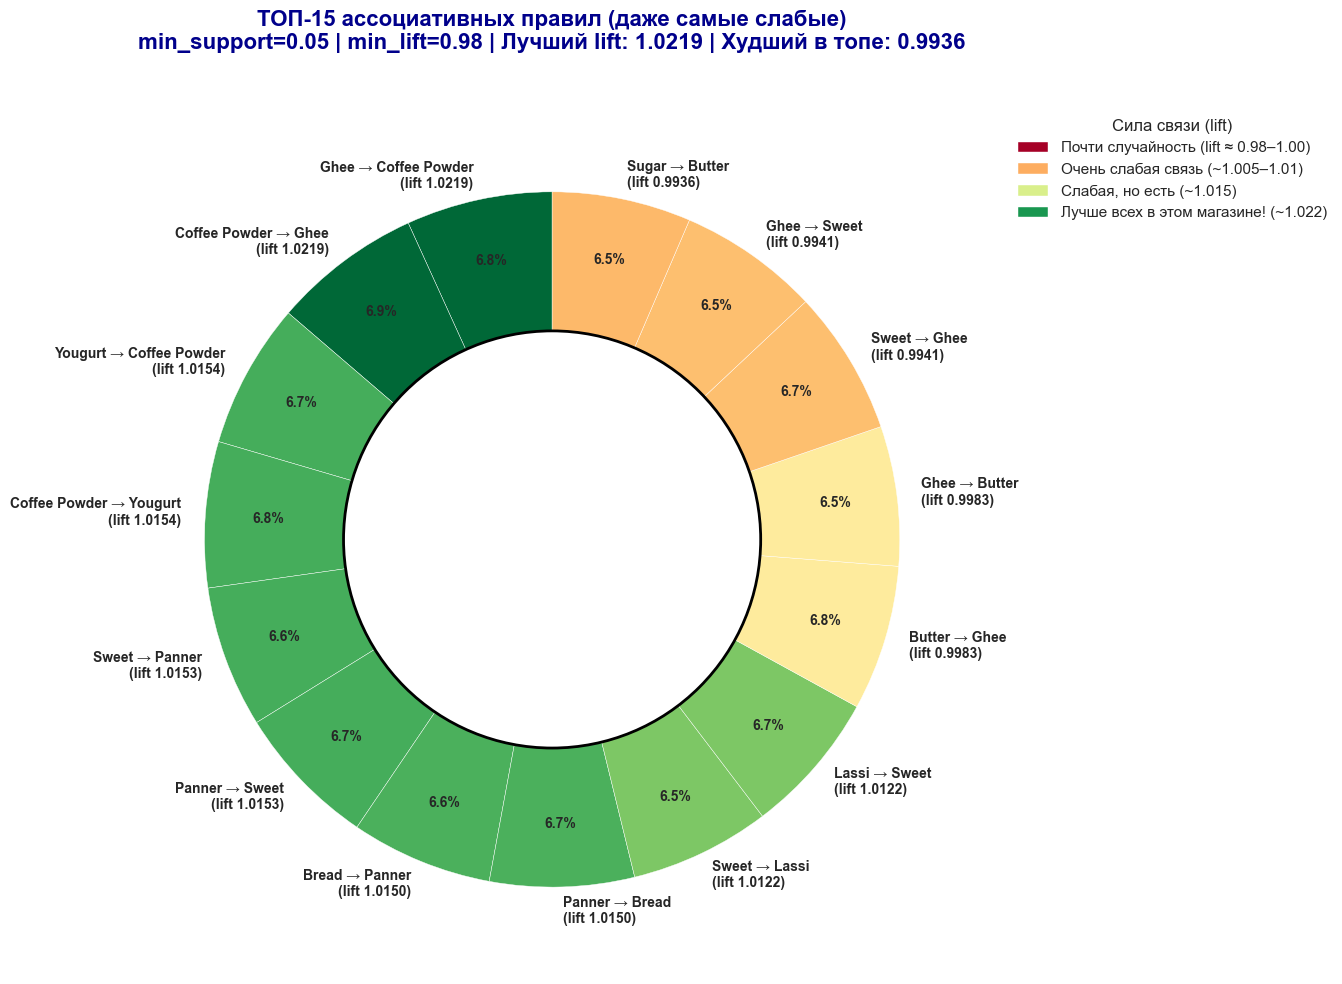

In [111]:
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import fpgrowth, association_rules

def plot_ultra_donut_rules(data, min_support=0.05, min_lift=0.98, top_n=15):

    freq_items = fpgrowth(data, min_support=min_support, use_colnames=True)
    rules = association_rules(freq_items, metric="lift", min_threshold=min_lift)

    if rules.empty:
        print("Нет правил с такими мягкими настройками :(")
        return

    rules = rules.sort_values('lift', ascending=False).head(top_n)

    rules['ante'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
    rules['cons'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))
    labels = [f"{a} → {c}\n(lift {l:.4f})"
              for a, c, l in zip(rules['ante'], rules['cons'], rules['lift'])]

    sizes = rules['confidence'] * 100

    lift_values = rules['lift'].values
    normalized_lift = (lift_values - 0.98) / (lift_values.max() - 0.98 + 0.0001)
    colors = plt.cm.RdYlGn(normalized_lift.clip(0, 1))

    plt.figure(figsize=(14, 10))
    wedges, texts, autotexts = plt.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        textprops={'fontsize': 10, 'fontweight': 'bold'},
        labeldistance=1.07,
        pctdistance=0.82,
        wedgeprops=dict(width=0.4, edgecolor='white')  # толще кольцо
    )

    centre_circle = plt.Circle((0,0), 0.60, fc='white', edgecolor='black', linewidth=2)
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.title(
        f'ТОП-{len(rules)} ассоциативных правил (даже самые слабые)\n'
        f'min_support={min_support} | min_lift={min_lift} | '
        f'Лучший lift: {rules["lift"].iloc[0]:.4f} | '
        f'Худший в топе: {rules["lift"].iloc[-1]:.4f}',
        fontsize=16, fontweight='bold', pad=40, color='darkblue'
    )

    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=plt.cm.RdYlGn(0.0), label=f'Почти случайность (lift ≈ 0.98–1.00)'),
        Patch(facecolor=plt.cm.RdYlGn(0.3), label=f'Очень слабая связь (~1.005–1.01)'),
        Patch(facecolor=plt.cm.RdYlGn(0.6), label=f'Слабая, но есть (~1.015)'),
        Patch(facecolor=plt.cm.RdYlGn(0.9), label=f'Лучше всех в этом магазине! (~1.022)'),
    ]
    plt.legend(handles=legend_elements, title="Сила связи (lift)",
               loc="upper left", bbox_to_anchor=(1.02, 1), fontsize=11)

    plt.tight_layout()
    plt.show()

plot_ultra_donut_rules(data, min_support=0.05, min_lift=0.98, top_n=15)